In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [2]:
# Base directory for the dataset
dataset_base = 'archive'

# Subdirectories for training and testing sets
train_dir = os.path.join(dataset_base, 'Training')
test_dir = os.path.join(dataset_base, 'Testing')

# Subdirectories for each type of tumor in the training and testing sets
train_glioma_dir = os.path.join(train_dir, 'glioma')
train_meningioma_dir = os.path.join(train_dir, 'meningioma')
train_notumor_dir = os.path.join(train_dir, 'notumor')
train_pituitary_dir = os.path.join(train_dir, 'pituitary')

test_glioma_dir = os.path.join(test_dir, 'glioma')
test_meningioma_dir = os.path.join(test_dir, 'meningioma')
test_notumor_dir = os.path.join(test_dir, 'notumor')
test_pituitary_dir = os.path.join(test_dir, 'pituitary')

# Function to print the number of images in each subdirectory
def print_dataset_details():
    print(f"Number of glioma images in training set: {len(os.listdir(train_glioma_dir))}")
    print(f"Number of meningioma images in training set: {len(os.listdir(train_meningioma_dir))}")
    print(f"Number of no-tumor images in training set: {len(os.listdir(train_notumor_dir))}")
    print(f"Number of pituitary images in training set: {len(os.listdir(train_pituitary_dir))}\n")

    print(f"Number of glioma images in testing set: {len(os.listdir(test_glioma_dir))}")
    print(f"Number of meningioma images in testing set: {len(os.listdir(test_meningioma_dir))}")
    print(f"Number of no-tumor images in testing set: {len(os.listdir(test_notumor_dir))}")
    print(f"Number of pituitary images in testing set: {len(os.listdir(test_pituitary_dir))}")

# Calling the function to print the details
print_dataset_details()


Number of glioma images in training set: 1321
Number of meningioma images in training set: 1339
Number of no-tumor images in training set: 1595
Number of pituitary images in training set: 1457

Number of glioma images in testing set: 300
Number of meningioma images in testing set: 306
Number of no-tumor images in testing set: 405
Number of pituitary images in testing set: 300


Preparing training data generator...
Found 5712 images belonging to 4 classes.
Preparing testing data generator...
Found 1311 images belonging to 4 classes.
Sample training batch shape (features): (32, 256, 256, 3)
Sample training batch shape (labels): (32, 4)
Sample validation batch shape (features): (32, 256, 256, 3)
Sample validation batch shape (labels): (32, 4)
Sample batch shape: (32, 256, 256, 3)
Sample label shape: (32, 4)
Found 5712 images belonging to 4 classes.


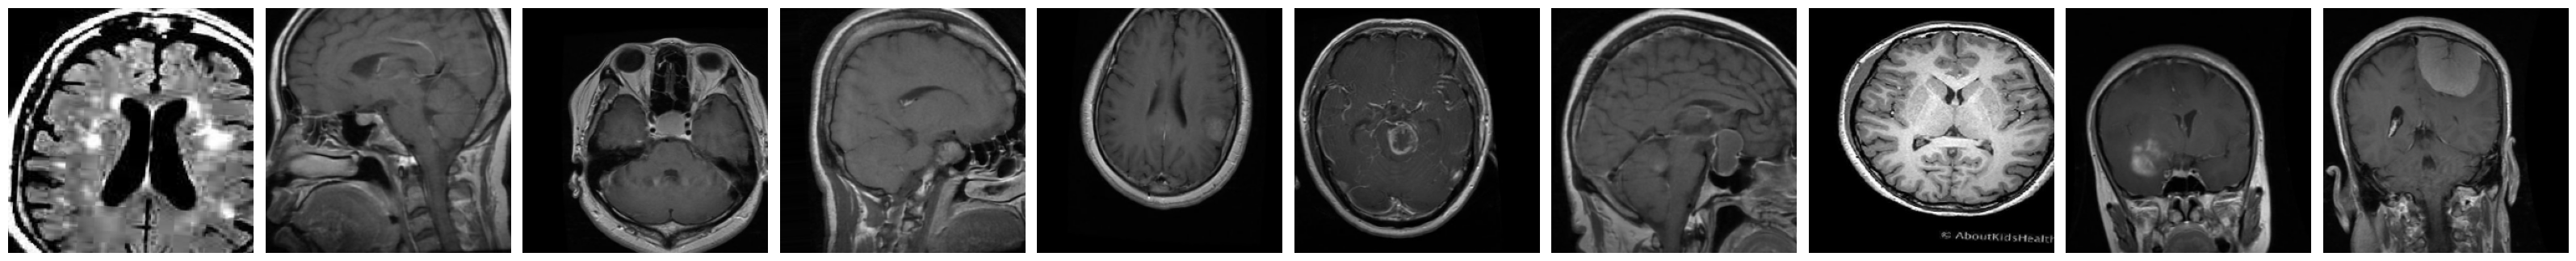

In [3]:
# Defining image size, batch size and number of classes
image_size = (256, 256)
batch_size = 32
num_classes = 4  # glioma, meningioma, notumor, pituitary


train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image pixels to [0,1]
    rotation_range=5,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly translate images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly translate images vertically (fraction of total height)
    shear_range=0.1,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=[1.0, 0.8],  # Range for random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Set the fill mode
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test set

# Flow training images in batches using train_datagen generator
print("Preparing training data generator...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # "categorical" for multi-class classification
    shuffle=True
)

# Flow validation images in batches using test_datagen generator
print("Preparing testing data generator...")
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
# Verifying the generator by getting a batch of images and labels
x_train_sample, y_train_sample = next(train_generator)
print("Sample training batch shape (features):", x_train_sample.shape)
print("Sample training batch shape (labels):", y_train_sample.shape)

x_val_sample, y_val_sample = next(validation_generator)
print("Sample validation batch shape (features):", x_val_sample.shape)
print("Sample validation batch shape (labels):", y_val_sample.shape)


# Verifying the generator by getting a batch of images
x_train_sample, y_train_sample = next(train_generator)
print(f"Sample batch shape: {x_train_sample.shape}")  # Should be (batch_size, *image_size, 3)
print(f"Sample label shape: {y_train_sample.shape}")  # Should be (batch_size, num_classes)

def show_augmented_images(image_data_generator, directory, num_images=10):
    # Create a temporary generator with no shuffle to always get the same images
    temp_generator = image_data_generator.flow_from_directory(
        directory,
        target_size=(256, 256),  # Ensure this matches your expected input size
        batch_size=num_images,
        class_mode='categorical',
        shuffle=True)

    # Get a batch of images
    images, labels = next(temp_generator)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(32, 32))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_augmented_images(train_datagen, train_dir)


In [4]:
def create_classification_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
model = create_classification_model((256, 256, 3), num_classes)



In [5]:
# Define callbacks after the model has been created
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    verbose=1, 
    mode='max', 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_classification_model', 
    monitor='val_accuracy', 
    mode='max', 
    save_best_only=True, 
    verbose=1
)


In [6]:
# Check generator output shape
x_sample, y_sample = next(train_generator)
print("Input shape:", x_sample.shape)
print("Output shape:", y_sample.shape)

# Run a manual prediction
y_pred_sample = model.predict(x_sample)
print("Predicted output shape:", y_pred_sample.shape)


Input shape: (32, 256, 256, 3)
Output shape: (32, 4)
1/1 [==============================] - 1s 537ms/step
Predicted output shape: (32, 4)


Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.5819
Epoch 1: val_accuracy improved from -inf to 0.66514, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 297s 2s/step - loss: 0.9756 - accuracy: 0.5819 - val_loss: 0.9184 - val_accuracy: 0.6651
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.7139
Epoch 2: val_accuracy improved from 0.66514 to 0.69947, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 236s 1s/step - loss: 0.7133 - accuracy: 0.7139 - val_loss: 0.8324 - val_accuracy: 0.6995
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.7479
Epoch 3: val_accuracy did not improve from 0.69947
179/179 [==============================] - 237s 1s/step - loss: 0.6425 - accuracy: 0.7479 - val_loss: 0.9276 - val_accuracy: 0.6796
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7763
Epoch 4: val_accuracy improved from 0.69947 to 0.71548, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 237s 1s/step - loss: 0.5665 - accuracy: 0.7763 - val_loss: 0.7677 - val_accuracy: 0.7155
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7785
Epoch 5: val_accuracy improved from 0.71548 to 0.73684, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 220s 1s/step - loss: 0.5702 - accuracy: 0.7785 - val_loss: 0.7430 - val_accuracy: 0.7368
Epoch 6/100
179/179 [==============================] - ETA: 0s - loss: 0.5267 - accuracy: 0.7838
Epoch 6: val_accuracy improved from 0.73684 to 0.77651, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 228s 1s/step - loss: 0.5267 - accuracy: 0.7838 - val_loss: 0.6071 - val_accuracy: 0.7765
Epoch 7/100
179/179 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.8020
Epoch 7: val_accuracy did not improve from 0.77651
179/179 [==============================] - 222s 1s/step - loss: 0.5083 - accuracy: 0.8020 - val_loss: 0.5991 - val_accuracy: 0.7559
Epoch 8/100
179/179 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.8185
Epoch 8: val_accuracy did not improve from 0.77651
179/179 [==============================] - 227s 1s/step - loss: 0.4721 - accuracy: 0.8185 - val_loss: 0.7498 - val_accuracy: 0.7468
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.8172
Epoch 9: val_accuracy improved from 0.77651 to 0.79024, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 255s 1s/step - loss: 0.4536 - accuracy: 0.8172 - val_loss: 0.5546 - val_accuracy: 0.7902
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8319
Epoch 10: val_accuracy did not improve from 0.79024
179/179 [==============================] - 218s 1s/step - loss: 0.4451 - accuracy: 0.8319 - val_loss: 0.5565 - val_accuracy: 0.7666
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.4199 - accuracy: 0.8353
Epoch 11: val_accuracy did not improve from 0.79024
179/179 [==============================] - 218s 1s/step - loss: 0.4199 - accuracy: 0.8353 - val_loss: 0.5150 - val_accuracy: 0.7712
Epoch 12/100
179/179 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8526
Epoch 12: val_accuracy improved from 0.79024 to 0.80931, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 254s 1s/step - loss: 0.3810 - accuracy: 0.8526 - val_loss: 0.4907 - val_accuracy: 0.8093
Epoch 13/100
179/179 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8519
Epoch 13: val_accuracy did not improve from 0.80931
179/179 [==============================] - 272s 2s/step - loss: 0.3910 - accuracy: 0.8519 - val_loss: 0.7166 - val_accuracy: 0.7483
Epoch 14/100
179/179 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8561
Epoch 14: val_accuracy did not improve from 0.80931
179/179 [==============================] - 325s 2s/step - loss: 0.3812 - accuracy: 0.8561 - val_loss: 0.5009 - val_accuracy: 0.7902
Epoch 15/100
179/179 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8678
Epoch 15: val_accuracy improved from 0.80931 to 0.81388, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 246s 1s/step - loss: 0.3536 - accuracy: 0.8678 - val_loss: 0.4369 - val_accuracy: 0.8139
Epoch 16/100
179/179 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8636
Epoch 16: val_accuracy improved from 0.81388 to 0.84973, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 267s 1s/step - loss: 0.3602 - accuracy: 0.8636 - val_loss: 0.3654 - val_accuracy: 0.8497
Epoch 17/100
179/179 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8766
Epoch 17: val_accuracy did not improve from 0.84973
179/179 [==============================] - 235s 1s/step - loss: 0.3328 - accuracy: 0.8766 - val_loss: 0.5110 - val_accuracy: 0.8047
Epoch 18/100
179/179 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8759
Epoch 18: val_accuracy did not improve from 0.84973
179/179 [==============================] - 232s 1s/step - loss: 0.3279 - accuracy: 0.8759 - val_loss: 0.3925 - val_accuracy: 0.8246
Epoch 19/100
179/179 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8764
Epoch 19: val_accuracy did not improve from 0.84973
179/179 [==============================] - 218s 1s/step - loss: 0.3266 - accuracy: 0.8764 - val_loss: 0.4411 - val_accuracy: 0.8291
Epoch 20/100
179/179 [

INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 224s 1s/step - loss: 0.3049 - accuracy: 0.8843 - val_loss: 0.3742 - val_accuracy: 0.8680
Epoch 22/100
179/179 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8880
Epoch 22: val_accuracy improved from 0.86804 to 0.87262, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 266s 1s/step - loss: 0.2931 - accuracy: 0.8880 - val_loss: 0.3386 - val_accuracy: 0.8726
Epoch 23/100
179/179 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8932
Epoch 23: val_accuracy did not improve from 0.87262
179/179 [==============================] - 232s 1s/step - loss: 0.2913 - accuracy: 0.8932 - val_loss: 0.4010 - val_accuracy: 0.8551
Epoch 24/100
179/179 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8953
Epoch 24: val_accuracy did not improve from 0.87262
179/179 [==============================] - 219s 1s/step - loss: 0.2831 - accuracy: 0.8953 - val_loss: 0.3680 - val_accuracy: 0.8596
Epoch 25/100
179/179 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.8930
Epoch 25: val_accuracy did not improve from 0.87262
179/179 [==============================] - 216s 1s/step - loss: 0.2870 - accuracy: 0.8930 - val_loss: 0.3693 - val_accuracy: 0.8528
Epoch 26/100
179/179 [

INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 215s 1s/step - loss: 0.2751 - accuracy: 0.8967 - val_loss: 0.2842 - val_accuracy: 0.8856
Epoch 27/100
179/179 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9023
Epoch 27: val_accuracy did not improve from 0.88558
179/179 [==============================] - 212s 1s/step - loss: 0.2573 - accuracy: 0.9023 - val_loss: 0.3054 - val_accuracy: 0.8802
Epoch 28/100
179/179 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.9065
Epoch 28: val_accuracy improved from 0.88558 to 0.89626, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 244s 1s/step - loss: 0.2602 - accuracy: 0.9065 - val_loss: 0.2654 - val_accuracy: 0.8963
Epoch 29/100
179/179 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9027
Epoch 29: val_accuracy did not improve from 0.89626
179/179 [==============================] - 298s 2s/step - loss: 0.2650 - accuracy: 0.9027 - val_loss: 0.2945 - val_accuracy: 0.8871
Epoch 30/100
179/179 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9093 
Epoch 30: val_accuracy did not improve from 0.89626
179/179 [==============================] - 3726s 21s/step - loss: 0.2436 - accuracy: 0.9093 - val_loss: 0.2654 - val_accuracy: 0.8818
Epoch 31/100
179/179 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9146
Epoch 31: val_accuracy did not improve from 0.89626
179/179 [==============================] - 267s 1s/step - loss: 0.2375 - accuracy: 0.9146 - val_loss: 0.4357 - val_accuracy: 0.8421
Epoch 32/100
179/17

INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 302s 2s/step - loss: 0.2136 - accuracy: 0.9219 - val_loss: 0.2328 - val_accuracy: 0.9001
Epoch 37/100
179/179 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9203
Epoch 37: val_accuracy improved from 0.90008 to 0.91228, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 295s 2s/step - loss: 0.2158 - accuracy: 0.9203 - val_loss: 0.2263 - val_accuracy: 0.9123
Epoch 38/100
179/179 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9209
Epoch 38: val_accuracy did not improve from 0.91228
179/179 [==============================] - 256s 1s/step - loss: 0.2139 - accuracy: 0.9209 - val_loss: 0.2911 - val_accuracy: 0.8795
Epoch 39/100
179/179 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9258
Epoch 39: val_accuracy did not improve from 0.91228
179/179 [==============================] - 246s 1s/step - loss: 0.2133 - accuracy: 0.9258 - val_loss: 0.2281 - val_accuracy: 0.9085
Epoch 40/100
179/179 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9219
Epoch 40: val_accuracy did not improve from 0.91228
179/179 [==============================] - 229s 1s/step - loss: 0.2124 - accuracy: 0.9219 - val_loss: 0.3457 - val_accuracy: 0.8818
Epoch 41/100
179/179 [

INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 213s 1s/step - loss: 0.1932 - accuracy: 0.9300 - val_loss: 0.1991 - val_accuracy: 0.9260
Epoch 46/100
179/179 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9305
Epoch 46: val_accuracy did not improve from 0.92601
179/179 [==============================] - 338s 2s/step - loss: 0.2073 - accuracy: 0.9305 - val_loss: 0.2988 - val_accuracy: 0.8894
Epoch 47/100
179/179 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9398
Epoch 47: val_accuracy did not improve from 0.92601
179/179 [==============================] - 470s 3s/step - loss: 0.1740 - accuracy: 0.9398 - val_loss: 0.3255 - val_accuracy: 0.8833
Epoch 48/100
179/179 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9312
Epoch 48: val_accuracy improved from 0.92601 to 0.93059, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 413s 2s/step - loss: 0.1796 - accuracy: 0.9312 - val_loss: 0.1877 - val_accuracy: 0.9306
Epoch 49/100
179/179 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9315
Epoch 49: val_accuracy did not improve from 0.93059
179/179 [==============================] - 236s 1s/step - loss: 0.1774 - accuracy: 0.9315 - val_loss: 0.2128 - val_accuracy: 0.9207
Epoch 50/100
179/179 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9394
Epoch 50: val_accuracy did not improve from 0.93059
179/179 [==============================] - 300s 2s/step - loss: 0.1636 - accuracy: 0.9394 - val_loss: 0.2118 - val_accuracy: 0.9176
Epoch 51/100
179/179 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9421
Epoch 51: val_accuracy did not improve from 0.93059
179/179 [==============================] - 266s 1s/step - loss: 0.1661 - accuracy: 0.9421 - val_loss: 0.3655 - val_accuracy: 0.8856
Epoch 52/100
179/179 [

INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 215s 1s/step - loss: 0.1608 - accuracy: 0.9431 - val_loss: 0.1602 - val_accuracy: 0.9329
Epoch 55/100
179/179 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9419
Epoch 55: val_accuracy improved from 0.93288 to 0.94432, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 212s 1s/step - loss: 0.1575 - accuracy: 0.9419 - val_loss: 0.1367 - val_accuracy: 0.9443
Epoch 56/100
179/179 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9417
Epoch 56: val_accuracy did not improve from 0.94432
179/179 [==============================] - 211s 1s/step - loss: 0.1609 - accuracy: 0.9417 - val_loss: 0.2305 - val_accuracy: 0.9100
Epoch 57/100
179/179 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9421
Epoch 57: val_accuracy did not improve from 0.94432
179/179 [==============================] - 209s 1s/step - loss: 0.1524 - accuracy: 0.9421 - val_loss: 0.1774 - val_accuracy: 0.9275
Epoch 58/100
179/179 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9447
Epoch 58: val_accuracy did not improve from 0.94432
179/179 [==============================] - 212s 1s/step - loss: 0.1517 - accuracy: 0.9447 - val_loss: 0.2401 - val_accuracy: 0.9169
Epoch 59/100
179/179 [

INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 226s 1s/step - loss: 0.1547 - accuracy: 0.9424 - val_loss: 0.1326 - val_accuracy: 0.9504
Epoch 61/100
179/179 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9442
Epoch 61: val_accuracy did not improve from 0.95042
179/179 [==============================] - 283s 2s/step - loss: 0.1527 - accuracy: 0.9442 - val_loss: 0.2163 - val_accuracy: 0.9214
Epoch 62/100
179/179 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9471
Epoch 62: val_accuracy improved from 0.95042 to 0.95500, saving model to best_classification_model
INFO:tensorflow:Assets written to: best_classification_model\assets


INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 258s 1s/step - loss: 0.1410 - accuracy: 0.9471 - val_loss: 0.1124 - val_accuracy: 0.9550
Epoch 63/100
179/179 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9492
Epoch 63: val_accuracy did not improve from 0.95500
179/179 [==============================] - 238s 1s/step - loss: 0.1422 - accuracy: 0.9492 - val_loss: 0.1716 - val_accuracy: 0.9443
Epoch 64/100
179/179 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9473
Epoch 64: val_accuracy did not improve from 0.95500
179/179 [==============================] - 247s 1s/step - loss: 0.1458 - accuracy: 0.9473 - val_loss: 0.1304 - val_accuracy: 0.9443
Epoch 65/100
179/179 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9491
Epoch 65: val_accuracy did not improve from 0.95500
179/179 [==============================] - 258s 1s/step - loss: 0.1397 - accuracy: 0.9491 - val_loss: 0.1624 - val_accuracy: 0.9359
Epoch 66/100
179/179 [

INFO:tensorflow:Assets written to: best_classification_model\assets


179/179 [==============================] - 233s 1s/step - loss: 0.1236 - accuracy: 0.9543 - val_loss: 0.0994 - val_accuracy: 0.9580
Epoch 72/100
179/179 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9477
Epoch 72: val_accuracy did not improve from 0.95805
179/179 [==============================] - 231s 1s/step - loss: 0.1430 - accuracy: 0.9477 - val_loss: 0.1723 - val_accuracy: 0.9329
Epoch 73/100
179/179 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9519
Epoch 73: val_accuracy did not improve from 0.95805
179/179 [==============================] - 230s 1s/step - loss: 0.1274 - accuracy: 0.9519 - val_loss: 0.3007 - val_accuracy: 0.9085
Epoch 74/100
179/179 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9533
Epoch 74: val_accuracy did not improve from 0.95805
179/179 [==============================] - 230s 1s/step - loss: 0.1311 - accuracy: 0.9533 - val_loss: 0.1583 - val_accuracy: 0.9314
Epoch 75/100
179/179 [

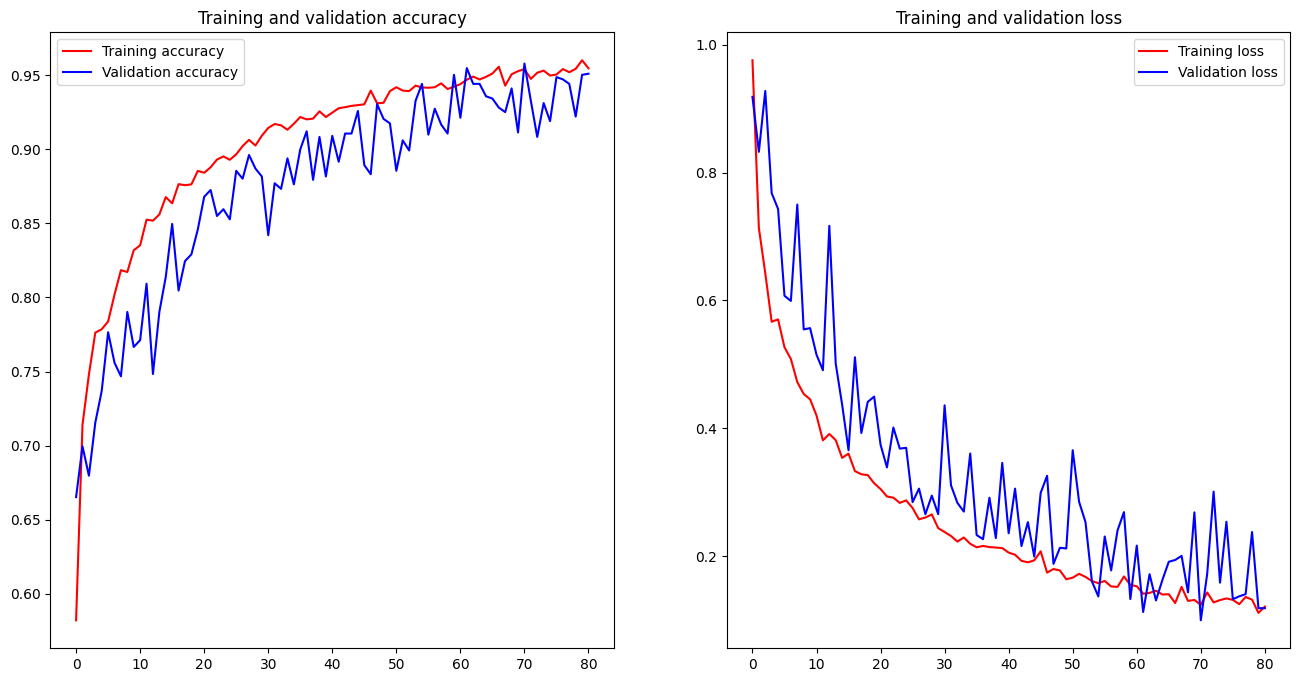

In [7]:
# Training the model using the fit_generator function
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,  # Adjust the number of epochs based on when convergence is observed
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, model_checkpoint]
)

# Visualizing the training history for accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Calling the function to plot the training history
plot_training_history(history)


In [8]:
model.save('final_classification_model2')

INFO:tensorflow:Assets written to: final_classification_model2\assets


INFO:tensorflow:Assets written to: final_classification_model2\assets


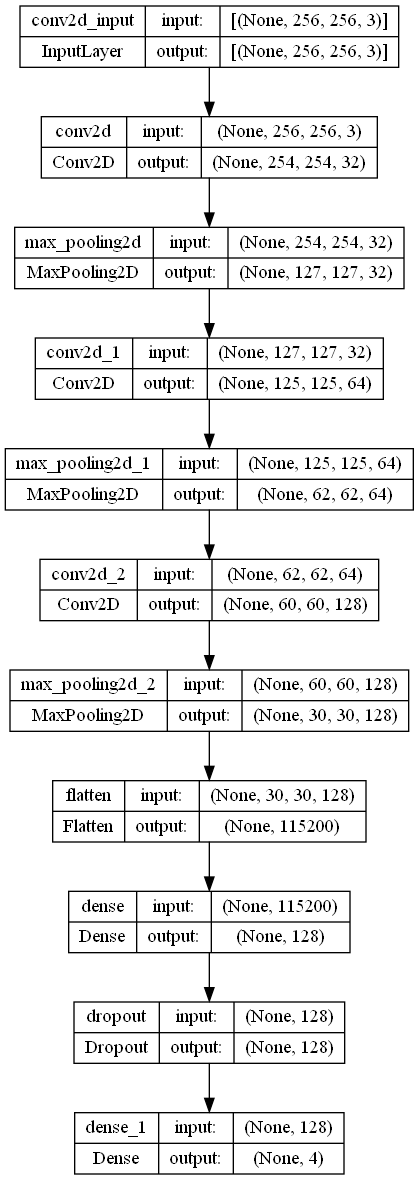

In [9]:
plot_model(model, to_file='model_architecture.png',show_shapes=True)


In [10]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model('final_classification_model2')


In [11]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 [==============================] - 29s 685ms/step - loss: 0.0994 - accuracy: 0.9580
Test Loss: 0.09943559020757675
Test Accuracy: 0.9580472707748413


In [12]:
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)


41/41 [==============================] - 29s 688ms/step


              precision    recall  f1-score   support

      glioma       0.25      0.23      0.24       300
  meningioma       0.23      0.24      0.24       306
     notumor       0.31      0.32      0.31       405
   pituitary       0.21      0.21      0.21       300

    accuracy                           0.25      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.25      0.25      0.25      1311



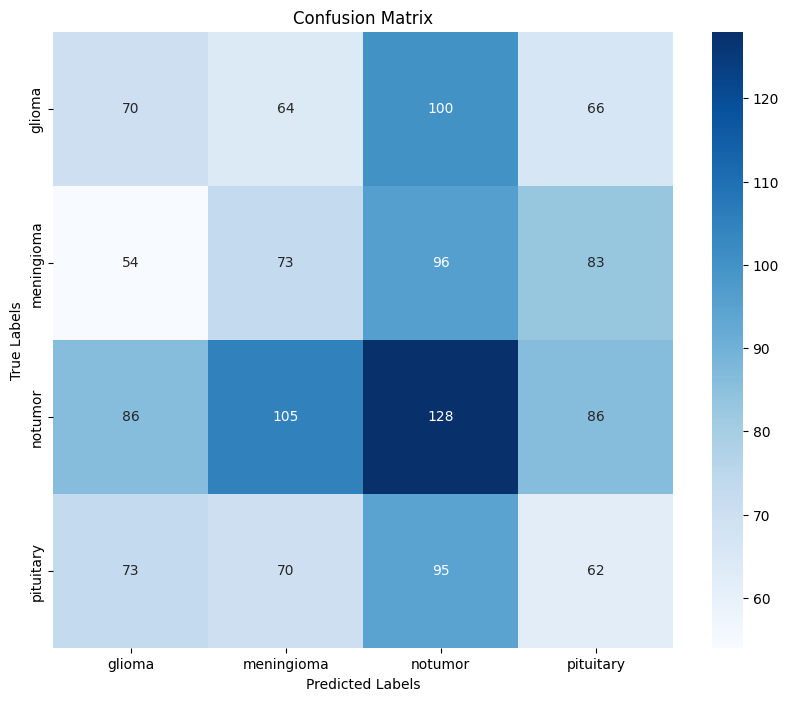

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate a classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Create a confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [14]:
import cv2

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    # Read the image using OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    # Resize the image to the target size
    img = cv2.resize(img, target_size)
    # Normalize the image
    img = img / 255.0
    # Add a batch dimension
    img = np.expand_dims(img, axis=0)
    return img

# Load your trained model
model = load_model('final_classification_model1')

# Path to a new image
image_path = "C:\\Users\\soora\\Downloads\\archive_2\\Testing\\glioma_tumor\\image(71).jpg"

# Preprocess the image
img = preprocess_image(image_path, target_size=(256, 256))

# Predict the class of the image
prediction = model.predict(img)
predicted_class_index = np.argmax(prediction, axis=1)

# Assuming you have a list of class names in the same order as your training data
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Replace with your actual class names

# Get the name of the predicted class
predicted_class_name = class_labels[predicted_class_index[0]]
print(f"Predicted class: {predicted_class_name}")


1/1 [==============================] - 0s 107ms/step
Predicted class: glioma
